In [1]:
import pandas as pd
import os
os.chdir(r'/home/root_gdut/KDD2025/old/embeddin')
import json
import networkx as nx
import datetime
import torch
from networkx.algorithms.community import greedy_modularity_communities, modularity
import sympy
from collections import deque
import numpy as np
from tqdm import tqdm
import scipy.integrate as integrate
import csv 

In [2]:
def load_vectors(file_path):
    vector_dict = {}
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.strip().split(',', 1)  # 按逗号分割，第一部分是推文ID，第二部分是向量
            tweet_id = parts[0]  # 获取推文ID
            try:
                # 将向量部分按空格拆分并转换为浮动数值
                vector = np.array([float(x) for x in parts[1].split()])  # 向量部分按空格拆分
                vector_dict[tweet_id] = vector
            except ValueError as e:
                print(f"无法将以下值转换为浮动数值: {parts[1]}. 错误信息: {e}")
    return vector_dict

# 调用方法
vector_dict = load_vectors("output_vectors.txt")
print(f"已加载的推文ID数量: {len(vector_dict)}")
print(f"部分推文ID: {list(vector_dict.keys())[:10]}") 

已加载的推文ID数量: 13250
部分推文ID: ['1371366321309556736', '1373893479160549376', '1377151142170222592', '1382037657291735040', '1384423637067911168', '1384656967998656512', '1386254705878310912', '1387712331891757056', '1388692619727884288', '1390579956292411392']


In [3]:
scores = 0.90
sentiment_df = pd.read_csv('final_with_sentiment.csv')

# 创建一个字典，方便通过 `id_str` 查找情感概率
sentiment_dict = {
    row['raw_value.id_str']: {
        'negative_probability': row['negative_probability'],
        'neutral_probability': row['neutral_probability'],
        'positive_probability': row['positive_probability']
    }
    for _, row in sentiment_df.iterrows()
}

def calculate_daw(time_diff_days):
    """根据时间差计算动态衰减指数DAW"""
    # 计算衰减因子，时间差转化为月单位
    time_diff_months = abs(time_diff_days) / 30

    # 使用数值积分替代符号积分
    result, error = integrate.quad(lambda x: np.exp(-x), 0, time_diff_months)
    
    # 计算DAW值，1减去积分结果
    daw_value = 1 - result
    
    # 保证DAW的下限为0.01
    return daw_value if daw_value >= 0.01 else 0.01

In [4]:
# 更新vol函数，整合DAW计算
def vol(parent_raws, emtions1, retweet_count, quote_count, favorite_count, reply_count,
        max_retweet_count, max_quote_count, max_favorite_count, max_reply_count, current_time):
    emtions = emtions1
    vol1 = 0
    if parent_raws:
        for raw in parent_raws:  # 0:相似度，1：相差时间，2：情感得分
            # 确保 raw[1] 是 pandas Timestamp 类型
            raw_time = pd.to_datetime(raw[1])  # 将父节点时间转换为 Timestamp 类型
            current_time = pd.to_datetime(current_time)  # 确保 current_time 是 Timestamp 类型
            
            # 计算时间差（天数）
            time_diff = (current_time - raw_time).days  # 获取天数差
            daw_value = calculate_daw(time_diff)  # 计算DAW
            vol1 += daw_value * raw[0] * raw[2]  # 根据DAW、相似度、情感得分计算传播强度
        vol1 /= len(parent_raws)
    # 父节点的平均情感 + 子节点情感 * 子节点的相关指标
    #print('emotion:', emtions, 'volumn:', vol1)
    emtions += vol1
    if emtions < -1:
        emtions = -1
    elif emtions > 1:
        emtions = 1
    return emtions

def emtions(tweet_id):
    # 直接通过 tweet_id 获取情感概率
    sentiment_probs = sentiment_dict.get(tweet_id)
    if sentiment_probs:
        negative_prob = sentiment_probs['negative_probability']
        neutral_prob = sentiment_probs['neutral_probability']
        positive_prob = sentiment_probs['positive_probability']

        # 计算情感分数
        if positive_prob > neutral_prob and positive_prob > negative_prob:
            sentiment_score = positive_prob
        elif negative_prob > neutral_prob and negative_prob > positive_prob:
            sentiment_score = -negative_prob
        elif neutral_prob > positive_prob and neutral_prob > negative_prob:
            if positive_prob > negative_prob:
                sentiment_score = 1 - neutral_prob
            else:
                sentiment_score = -(1 - neutral_prob)
    else:
        sentiment_score = 0  # 如果找不到情感概率，返回默认值（例如0）

    return sentiment_score

In [5]:
import csv
from collections import deque
def cosine(x, y):
    # 确保x和y是tensor类型
    x = torch.tensor(x)
    y = torch.tensor(y)
    
    # 计算余弦相似度
    return torch.nn.functional.cosine_similarity(x.unsqueeze(0), y.unsqueeze(0))
def bert_va(tweet_id, emtions1):
    tweet_id = str(tweet_id)  # 确保tweet_id是字符串类型
    if tweet_id not in vector_dict:
        raise ValueError(f"向量文件中找不到推文ID {tweet_id}")
    
    tweet_vector = vector_dict[tweet_id]
    embedding_with_emotion = np.concatenate((tweet_vector, np.array([emtions1])), axis=0)
    
    return embedding_with_emotion

In [70]:
G = nx.DiGraph()

# 读取数据并进行初步处理
table = pd.read_csv("final.txt")
table = table.iloc[:, 1:]  # 删除第一列，如果是索引列
table['raw_value.created_at'] = pd.to_datetime(table['raw_value.created_at'])

# 确保数据按创建时间排序
table = table.sort_values(by='raw_value.created_at')

table.index = table['raw_value.created_at']  # 将时间列设置为索引

# 初始化数据结构
users = {i: {} for i in set(table['raw_value.user_id_str'].values.tolist())}
makelist = {}
emotionlist = {}
date_diff = 30  # 删除节点的时间差上限为30天

# 获取最大转发、引用、点赞和评论数量
max_retweet_count, max_quote_count, max_favorite_count, max_reply_count = (
    table['raw_value.retweet_count'].max(),
    table['raw_value.quote_count'].max(),
    table['raw_value.favorite_count'].max(),
    table['raw_value.reply_count'].max()
)

tweet_to_user = {}

# 使用双端队列缓存边的时间戳和对应的边
edge_timestamps = deque()  # 用于存储边的时间戳和对应的边

# 用于缓存时间段的计算结果
data_buffer = []  # 存储每个时间点的指标数据
date = []
# 打开 edge_log.csv 文件，用于记录连边信息
with open("edge_log.csv", "a+", newline='', encoding="utf-8") as edge_file:
    edge_writer = csv.writer(edge_file)
    # 如果文件为空，写入表头
    if edge_file.tell() == 0:
        edge_writer.writerow(['Source_Node', 'Target_Node', 'Timestamp'])
    
    # 按天分组数据进行处理
    for w, w_t in table.resample('D'):  # 每天处理一次数据
        if len(w_t) == 0:
            continue  # 如果这一天没有数据，跳过该天的处理
        date.append(w)
        current_time = w  # 使用当前时间作为当前时间
        new_edges_added = False  # 标记这一天是否有新增边或节点

        # 处理每一条推文数据
        for index, row in w_t.iterrows():
            strs = row['raw_value.full_text']
            strs2 = row['Tags']
            tweet_id = row['raw_value.id_str']  # 获取 tweet_id

            # 获取情感分数
            emtions1 = emtions(tweet_id)
            bert_va1 = bert_va(tweet_id, emtions1)
            this_data_datetime = row['raw_value.created_at']

            G.add_node(row['raw_value.id_str'])
            tweet_to_user[row['raw_value.id_str']] = row['raw_value.user_id_str']
            parent = []  # 存储相关的父节点

            # 遍历当前的 makelist，检查已有的边是否超过30天
            for make_i in makelist.keys():
                diff = (this_data_datetime - makelist[make_i]['created_at']).days
                if diff < date_diff:  # 如果时间差小于30天，继续检查
                    daw_value = calculate_daw(diff)
                    score = float(cosine(bert_va1, makelist[make_i]['pooled']) * daw_value)

                    if 1 > score > scores:  # 相似度阈值
                        # 添加带有时间戳的边
                        G.add_edge(makelist[make_i]['id'], row['raw_value.id_str'], weight=round(score, 2), timestamp=this_data_datetime)
                        
                        # 记录边的ID和时间戳到文件
                        edge_writer.writerow([makelist[make_i]['id'], row['raw_value.id_str'], this_data_datetime])
                        new_edges_added = True

            # 更新情感值
            emtions1 = vol(parent, emtions1, row['raw_value.retweet_count'], row['raw_value.quote_count'],
                           row['raw_value.favorite_count'], row['raw_value.reply_count'],
                           max_retweet_count, max_quote_count, max_favorite_count, max_reply_count, current_time)
            #score = float(emtions1+score) / 2)
            if w not in users[row['raw_value.user_id_str']].keys():
                users[row['raw_value.user_id_str']][w] = [emtions1]
            else:
                users[row['raw_value.user_id_str']][w].append(emtions1)

            # 更新节点信息
            makelist[row['raw_value.id_str']] = {
                'userid': row['raw_value.user_id_str'],
                'id': row['raw_value.id_str'],
                'text': row['raw_value.full_text'],
                'cleantext': strs,
                'emotion': emtions1,
                'pooled': bert_va1,
                'created_at': row['raw_value.created_at']
            }

        # 即使没有新节点或边，也要删除超过30天的节点和它们的边
        to_remove_nodes = set()  # 用于存储需要删除的节点

        # 检查每个节点是否存在超过30天
        for node in list(G.nodes):  # 使用 list() 避免在遍历中修改节点集合
            node_creation_time = makelist[node]['created_at']
            node_age = (current_time - node_creation_time).days
            if node_age > date_diff:  # 如果节点存在超过30天
                to_remove_nodes.add(node)

        # 删除超过30天的节点及其所有边
        for node in tqdm(to_remove_nodes):#, desc="删除过期节点", unit="节点"):
            if G.has_node(node):
                # 删除与该节点相关的所有边
                G.remove_node(node)
                #print(f"已删除节点及其所有边：{node}  (时间差超过 {date_diff} 天)")

        # 删除节点和边后，及时更新数据结构
        for node in to_remove_nodes:
            if node in makelist:
                del makelist[node]
            if node in tweet_to_user:
                del tweet_to_user[node]

        # 计算网络指标并缓存到内存
        if G.number_of_edges() > 0:
            d = dict(nx.degree(G))
            d_avg = sum(d.values()) / len(G.nodes)

            x = list(range(max(d.values()) + 1))
            d_list = nx.degree_histogram(G)
            y = np.array(d_list) / len(G)

            # 检测社区并计算模块化程度
            communities = greedy_modularity_communities(G.to_undirected())
            modularity_score = modularity(G.to_undirected(), communities, weight=None)

            q1 = G.number_of_nodes()  # 节点数
            q2 = G.number_of_edges()  # 边数
            q3 = nx.pagerank(G,alpha=0.85)
            q6 = nx.degree_assortativity_coefficient(G)  # 度同配系数

            # 将计算结果缓存到 data_buffer
            data_buffer.append([w.strftime('%Y-%m-%d'), q1, q2, q3, q6, modularity_score])

        # 批量写入文件
        if len(data_buffer) >= 10:  # 如果缓存的记录达到10个（可以根据需要调整）
            with open("index1.csv", 'a+', newline='', encoding='utf-8') as f:
                writer = csv.writer(f)
                if f.tell() == 0:  # 如果文件为空，先写入表头
                    writer.writerow(['Time', 'Num_nodes', 'Num_edges', 'PageRank', 'Degree_assortativity', 'Modularity'])
                #writer.writerows(data_buffer)  # 批量写入
            data_buffer.clear()  # 清空缓存

            # 可选：输出日志
            print(f"已批量写入 {len(data_buffer)} 条数据到 index1.csv")

        timestamp_str = w.strftime("%Y-%m-%d")
        adjacency_matrix = nx.adjacency_matrix(G).todense()
        #pd.DataFrame(adjacency_matrix, index=G.nodes, columns=G.nodes).to_csv(f'G-{timestamp_str}.csv')

        tweet_network_filename = f'tweet_network-{timestamp_str}.edgelist'
        nx.write_edgelist(G, tweet_network_filename)

        #with open("final_emotions1.csv", 'a+') as f:
        #    f.write(f"{timestamp_str},{emtions1}\n")

# 保存映射关系和其他信息
#with open("emotionall1.csv", "w+", encoding='utf-8') as f:
#    f.write(str(makelist))

# 保存tweet_to_user映射
#with open("tweet_to_user_mapping1.json", "w") as f:
#    json.dump(tweet_to_user, f)
print('over')
print(datetime.datetime.now())

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 15477.14it/s]
0it [00:00, ?it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12018.06it/s]
0it [00:00, ?it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 12192.74it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 34473.73it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it

已批量写入 0 条数据到 index1.csv


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 73584.28it/s]
/home/root_gdut/miniconda3/envs/network/lib/python3.9/site-packages/networkx/algorithms/assortativity/correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)
0it [00:00, ?it/s]
/home/root_gdut/miniconda3/envs/network/lib/python3.9/site-packages/networkx/algorithms/assortativity/correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)
0it [00:00, ?it/s]
/home/root_gdut/miniconda3/envs/network/lib/python3.9/site-packages/networkx/algorithms/assortativity/correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)
100%|███████████████████████████████████████████████████████

已批量写入 0 条数据到 index1.csv


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 20460.02it/s]
/home/root_gdut/miniconda3/envs/network/lib/python3.9/site-packages/networkx/algorithms/assortativity/correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)
0it [00:00, ?it/s]
/home/root_gdut/miniconda3/envs/network/lib/python3.9/site-packages/networkx/algorithms/assortativity/correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 73584.28it/s]
/home/root_gdut/miniconda3/envs/network/lib/python3.9/site-packages/networkx/algorithms/assortativity/correlation.py:

已批量写入 0 条数据到 index1.csv


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 49344.75it/s]
/home/root_gdut/miniconda3/envs/network/lib/python3.9/site-packages/networkx/algorithms/assortativity/correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 172550.48it/s]
/home/root_gdut/miniconda3/envs/network/lib/python3.9/site-packages/networkx/algorithms/assortativity/correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

已批量写入 0 条数据到 index1.csv


0it [00:00, ?it/s]
/home/root_gdut/miniconda3/envs/network/lib/python3.9/site-packages/networkx/algorithms/assortativity/correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 86659.17it/s]
/home/root_gdut/miniconda3/envs/network/lib/python3.9/site-packages/networkx/algorithms/assortativity/correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 114241.74it/s]
/home/root_gdut/miniconda3/envs/network/lib/python3.9/site-packages/networkx/algorithms/assortativity/correlation.py:

已批量写入 0 条数据到 index1.csv


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 75915.00it/s]
/home/root_gdut/miniconda3/envs/network/lib/python3.9/site-packages/networkx/algorithms/assortativity/correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 140853.49it/s]
/home/root_gdut/miniconda3/envs/network/lib/python3.9/site-packages/networkx/algorithms/assortativity/correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

已批量写入 0 条数据到 index1.csv


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 57719.78it/s]
/home/root_gdut/miniconda3/envs/network/lib/python3.9/site-packages/networkx/algorithms/assortativity/correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 117912.16it/s]
/home/root_gdut/miniconda3/envs/network/lib/python3.9/site-packages/networkx/algorithms/assortativity/correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

已批量写入 0 条数据到 index1.csv


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 321888.45it/s]


已批量写入 0 条数据到 index1.csv


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 88862.37it/s]


已批量写入 0 条数据到 index1.csv


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<00:00, 218833.25it/s]


已批量写入 0 条数据到 index1.csv


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 192989.45it/s]


已批量写入 0 条数据到 index1.csv


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 269700.26it/s]


已批量写入 0 条数据到 index1.csv


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 317269.59it/s]


已批量写入 0 条数据到 index1.csv


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 43/43 [00:00<00:00, 284921.12it/s]


已批量写入 0 条数据到 index1.csv


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [00:00<00:00, 406517.49it/s]


已批量写入 0 条数据到 index1.csv


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 251271.67it/s]


已批量写入 0 条数据到 index1.csv


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [00:00<00:00, 297357.37it/s]


已批量写入 0 条数据到 index1.csv


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28/28 [00:00<00:00, 245178.52it/s]


已批量写入 0 条数据到 index1.csv


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 58/58 [00:00<00:00, 292391.38it/s]


已批量写入 0 条数据到 index1.csv


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 236457.41it/s]


已批量写入 0 条数据到 index1.csv


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 68/68 [00:00<00:00, 239272.38it/s]


已批量写入 0 条数据到 index1.csv


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 239053.60it/s]


已批量写入 0 条数据到 index1.csv


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 41/41 [00:00<00:00, 247790.29it/s]


已批量写入 0 条数据到 index1.csv


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 73/73 [00:00<00:00, 359793.41it/s]


已批量写入 0 条数据到 index1.csv


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 138594.39it/s]


已批量写入 0 条数据到 index1.csv


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:00<00:00, 292481.14it/s]


已批量写入 0 条数据到 index1.csv


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 297509.74it/s]


已批量写入 0 条数据到 index1.csv


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 339497.97it/s]


已批量写入 0 条数据到 index1.csv


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 95/95 [00:00<00:00, 411206.27it/s]


已批量写入 0 条数据到 index1.csv


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:00<00:00, 150468.30it/s]


已批量写入 0 条数据到 index1.csv


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 36/36 [00:00<00:00, 205995.83it/s]


已批量写入 0 条数据到 index1.csv


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 259307.82it/s]


已批量写入 0 条数据到 index1.csv


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:00<00:00, 324076.98it/s]


已批量写入 0 条数据到 index1.csv


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 62/62 [00:00<00:00, 335977.84it/s]


已批量写入 0 条数据到 index1.csv


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 46/46 [00:00<00:00, 298665.61it/s]

over
2025-02-10 19:41:16.559713


In [7]:
import networkx as nx

def calculate_degree_centrality(G):
    """
    计算节点的度中心性
    """
    return nx.degree_centrality(G)

def calculate_betweenness_centrality(G):
    """
    计算节点的介数中心性
    """
    return nx.betweenness_centrality(G)

def calculate_closeness_centrality(G):
    """
    计算节点的接近中心性
    """
    return nx.closeness_centrality(G)

def calculate_information_spread_speed(G):
    """
    计算信息传播速度（假设为平均最短路径长度的倒数）
    """
    if nx.is_strongly_connected(G):
        avg_shortest_path_length = nx.average_shortest_path_length(G)
        return 1 / avg_shortest_path_length
    else:
        return 0  # 如果图不连通，传播速度为0

def calculate_information_spread_range(G):
    """
    计算信息传播范围（节点覆盖范围）
    """
    return len(G.nodes)

def calculate_information_spread_depth(G):
    """
    计算信息传播的最大深度（图的直径）
    """
    if nx.is_strongly_connected(G):
        return nx.diameter(G)
    else:
        return 0  # 如果图不连通，深度为0

def calculate_competition_intensity(G):
    """
    计算信息竞争强度（假设为节点之间的边权重之和）
    """
    competition_intensity = 0
    for u, v, data in G.edges(data=True):
        competition_intensity += data.get('weight', 1)  # 假设边权重表示竞争强度
    return competition_intensity

def calculate_collaboration_intensity(G):
    """
    计算信息协同强度（假设为节点之间的共同邻居数量）
    """
    G_undirected = G.to_undirected()  # 将有向图转换为无向图
    collaboration_intensity = 0
    for u in G_undirected.nodes():
        for v in G_undirected.nodes():
            if u != v:
                common_neighbors = len(list(nx.common_neighbors(G_undirected, u, v)))
                collaboration_intensity += common_neighbors
    return collaboration_intensity

# 主程序
if __name__ == "__main__":
    # 假设 G 已经通过你的代码构建完成
    # 计算信息生态位宽度
    degree_centrality = calculate_degree_centrality(G)
    betweenness_centrality = calculate_betweenness_centrality(G)
    closeness_centrality = calculate_closeness_centrality(G)

    # 计算信息繁衍状态
    spread_speed = calculate_information_spread_speed(G)
    spread_range = calculate_information_spread_range(G)
    spread_depth = calculate_information_spread_depth(G)

    # 计算信息间竞合关系
    competition_intensity = calculate_competition_intensity(G)
    collaboration_intensity = calculate_collaboration_intensity(G)

    # 输出结果
    print("Degree Centrality:", degree_centrality)
    print("Betweenness Centrality:", betweenness_centrality)
    print("Closeness Centrality:", closeness_centrality)
    print("Information Spread Speed:", spread_speed)
    print("Information Spread Range:", spread_range)
    print("Information Spread Depth:", spread_depth)
    print("Competition Intensity:", competition_intensity)
    print("Collaboration Intensity:", collaboration_intensity)

Degree Centrality: {1531430937447124992: 0.0, 1531446518330294272: 0.0, 1531449349682634752: 0.0, 1531455792489979904: 0.0, 1531465828800925696: 0.0, 1531465859251679232: 0.0, 1531471418990350336: 0.0, 1531473920729153536: 0.0006443298969072165, 1531476222735069184: 0.0006443298969072165, 1531476404789026816: 0.0, 1531477934095098112: 0.0, 1531479250263363584: 0.0006443298969072165, 1531480734568960000: 0.0, 1531481015167893504: 0.0006443298969072165, 1531482222355783680: 0.0, 1531489591655825408: 0.0006443298969072165, 1531500262929575936: 0.0, 1531504756664913920: 0.0, 1531515970409287680: 0.001288659793814433, 1531516429127720960: 0.0, 1531524901181734912: 0.001288659793814433, 1531536967086682112: 0.0, 1531538311549857792: 0.0, 1531539376479449088: 0.001288659793814433, 1531541016506863616: 0.0, 1531544355450023936: 0.0, 1531544680441475072: 0.0, 1531545414276612096: 0.0, 1531558947861041152: 0.0, 1531561135555497984: 0.0, 1531569701712605184: 0.0, 1531582048607080448: 0.0006443298

In [8]:
type(G)

networkx.classes.digraph.DiGraph

检测到社区数量: 118
桥接节点数量: 19
DCPRR得分示例: {0: np.float64(0.44), 4: np.float64(1.0), 11: np.float64(1.0), 19: np.float64(1.0), 26: np.float64(1.0)}
社区凝聚强度与边界渗透性的皮尔逊相关系数: -0.6379373135171116, p-value: 0.04719010380875565


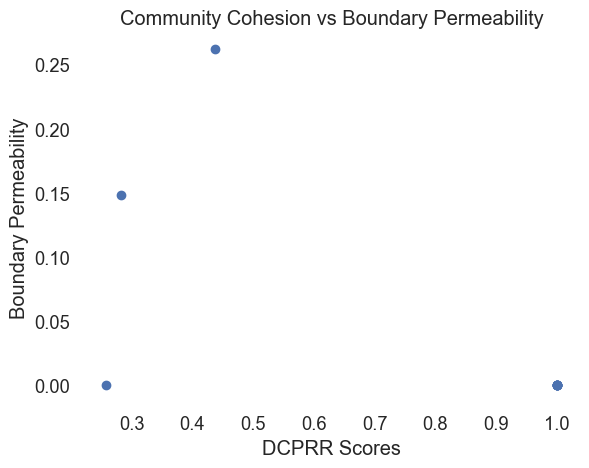

In [80]:
import networkx as nx
import community as community_louvain
import numpy as np
from collections import defaultdict
from scipy.stats import pearsonr
def detect_communities(G, min_community_size=12, resolution=2.0):
    """
    改进的社区检测函数，控制社区数量和大小。
    :param G: 图网络（有向图）
    :param min_community_size: 最小社区节点数（过滤小社区）
    :param resolution: Louvain算法的分辨率参数（值越大社区越多，默认1.0）
    :return: 合并后的社区字典、桥接节点集合
    """
    # 转换为无向图进行社区检测
    G_undirected = G.to_undirected()
    
    # 使用调整后的Louvain算法
    partition = community_louvain.best_partition(G_undirected, resolution=resolution)
    
    # 合并小社区
    communities = defaultdict(list)
    for node, comm_id in partition.items():
        communities[comm_id].append(node)
    
    # 过滤并重新编号社区
    valid_communities = {}
    new_comm_id = 0
    for comm_id, nodes in communities.items():
        if len(nodes) >= min_community_size:
            valid_communities[new_comm_id] = nodes
            new_comm_id += 1
        else:
            # 将小社区合并到最近的社区
            for node in nodes:
                neighbors = list(G.neighbors(node))
                if neighbors:
                    target_comm = partition[neighbors[0]]
                    valid_communities.setdefault(target_comm, []).append(node)
    
    # 重新编号社区ID以保证连续性
    final_communities = {i: nodes for i, (_, nodes) in enumerate(valid_communities.items())}
    
    # 桥接节点识别（基于合并后的社区）
    node_to_comm = {node: comm_id for comm_id, nodes in final_communities.items() for node in nodes}
    bridging_nodes = set()
    for node in G.nodes():
        if node not in node_to_comm:
            continue
        comm_id = node_to_comm[node]
        for neighbor in G.neighbors(node):
            if neighbor in node_to_comm and node_to_comm[neighbor] != comm_id:
                bridging_nodes.add(node)
                break
    
    return final_communities, bridging_nodes

def compute_dcprr_score(G, community_nodes, walk_length=100, num_walks=30):
    """
    改进的DCPRR得分计算，增加随机行走次数和路径长度。
    :param community_nodes: 社区节点列表
    :param walk_length: 单次随机行走步长
    :param num_walks: 每个节点的随机行走次数
    :return: DCPRR得分（范围[0,1]）
    """
    if len(community_nodes) < 2:
        return 0.0  # 社区太小无法计算
    
    retention_rates = []
    for node in community_nodes:
        if G.out_degree(node) == 0:
            continue  # 跳过无出边的节点
        
        total_steps = 0
        retained_steps = 0
        for _ in range(num_walks):
            current_node = node
            for _ in range(walk_length):
                neighbors = list(G.neighbors(current_node))
                if not neighbors:
                    break
                next_node = np.random.choice(neighbors)
                total_steps += 1
                if next_node in community_nodes:
                    retained_steps += 1
                current_node = next_node
        
        if total_steps > 0:
            retention_rates.append(retained_steps / total_steps)
    
    return np.mean(retention_rates) if retention_rates else 0.0

def calculate_all_dcprr_scores(G, communities):
    """
    计算所有有效社区的DCPRR得分。
    :return: {社区ID: DCPRR得分}
    """
    return {
        comm_id: compute_dcprr_score(G, nodes)
        for comm_id, nodes in communities.items()
        if len(nodes) >= 5  # 仅计算节点数≥5的社区
    }

def calculate_boundary_permeability(bridging_nodes, community_nodes):
    """
    计算社区的边界渗透性。
    :param bridging_nodes: 桥接节点集合
    :param community_nodes: 社区节点集合
    :return: 边界渗透性（桥接节点占总节点的比例）
    """
    if not community_nodes:
        return 0.0
    return len(set(bridging_nodes) & set(community_nodes)) / len(community_nodes)

# 在analyze_correlation函数中确保只处理有DCPRR得分的社区
def analyze_correlation(dcprr_scores, communities, bridging_nodes):
    """
    分析DCPRR得分与边界渗透性的负相关关系。
    :param dcprr_scores: 所有社区的DCPRR得分
    :param communities: 所有社区及其节点
    :param bridging_nodes: 桥接节点集合
    :return: 相关性系数和p值
    """
    boundary_permeabilities = [
        calculate_boundary_permeability(bridging_nodes, nodes)
        for comm_id, nodes in communities.items()
        if comm_id in dcprr_scores  # 确保只计算有DCPRR得分的社区
    ]
    correlation, p_value = pearsonr(list(dcprr_scores.values()), boundary_permeabilities)
    return correlation, p_value

# 使用示例
if __name__ == "__main__":
    # 假设G是已构建的图网络
    communities, bridging_nodes = detect_communities(G, min_community_size=10, resolution=0.8)
    dcprr_scores = calculate_all_dcprr_scores(G, communities)
    
    print(f"检测到社区数量: {len(communities)}")
    print(f"桥接节点数量: {len(bridging_nodes)}")
    print("DCPRR得分示例:", {k: round(v, 2) for k, v in list(dcprr_scores.items())[:5]})
    
    correlation, p_value = analyze_correlation(dcprr_scores, communities, bridging_nodes)
    print(f"社区凝聚强度与边界渗透性的皮尔逊相关系数: {correlation}, p-value: {p_value}")
    
    # 提取具有DCPRR得分的社区ID列表
    valid_community_ids = [comm_id for comm_id in communities.keys() if comm_id in dcprr_scores]
    
    # 计算对应的DCPRR得分和边界渗透性
    dcprr_values = [dcprr_scores[comm_id] for comm_id in valid_community_ids]
    boundary_permeabilities = [
        calculate_boundary_permeability(bridging_nodes, communities[comm_id])
        for comm_id in valid_community_ids
    ]
    
    # 绘制散点图
    plt.scatter(dcprr_values, boundary_permeabilities)
    plt.xlabel('DCPRR Scores')
    plt.ylabel('Boundary Permeability')
    plt.title('Community Cohesion vs Boundary Permeability')
    plt.show()

In [22]:
communities = sorted(dcprr_scores.keys(), key=lambda x: dcprr_scores[x], reverse=True)
communities

[4, 11, 19, 26, 55, 74, 107, 0, 73, 79]

In [65]:
import networkx as nx
import community as community_louvain
import numpy as np
from collections import defaultdict

def detect_communities(G, min_community_size=12, resolution=2.0):
    """
    改进的社区检测函数，控制社区数量和大小。
    :param G: 图网络（有向图）
    :param min_community_size: 最小社区节点数（过滤小社区）
    :param resolution: Louvain算法的分辨率参数（值越大社区越多，默认1.0）
    :return: 合并后的社区字典、桥接节点集合
    """
    # 转换为无向图进行社区检测
    G_undirected = G.to_undirected()
    
    # 使用调整后的Louvain算法
    partition = community_louvain.best_partition(G_undirected, resolution=resolution)
    
    # 合并小社区
    communities = defaultdict(list)
    for node, comm_id in partition.items():
        communities[comm_id].append(node)
    
    # 过滤并重新编号社区
    valid_communities = {}
    new_comm_id = 0
    for comm_id, nodes in communities.items():
        if len(nodes) >= min_community_size:
            valid_communities[new_comm_id] = nodes
            new_comm_id += 1
        else:
            # 将小社区合并到最近的社区
            for node in nodes:
                neighbors = list(G.neighbors(node))
                if neighbors:
                    target_comm = partition[neighbors[0]]
                    valid_communities.setdefault(target_comm, []).append(node)
    
    # 重新编号社区ID以保证连续性
    final_communities = {i: nodes for i, (_, nodes) in enumerate(valid_communities.items())}
    
    # 桥接节点识别（基于合并后的社区）
    node_to_comm = {node: comm_id for comm_id, nodes in final_communities.items() for node in nodes}
    bridging_nodes = set()
    for node in G.nodes():
        if node not in node_to_comm:
            continue
        comm_id = node_to_comm[node]
        for neighbor in G.neighbors(node):
            if neighbor in node_to_comm and node_to_comm[neighbor] != comm_id:
                bridging_nodes.add(node)
                break
    
    return final_communities, bridging_nodes

def compute_dcprr_score(G, community_nodes, walk_length=100, num_walks=30):
    """
    改进的DCPRR得分计算，增加随机行走次数和路径长度。
    :param community_nodes: 社区节点列表
    :param walk_length: 单次随机行走步长
    :param num_walks: 每个节点的随机行走次数
    :return: DCPRR得分（范围[0,1]）
    """
    if len(community_nodes) < 2:
        return 0.0  # 社区太小无法计算
    
    retention_rates = []
    for node in community_nodes:
        if G.out_degree(node) == 0:
            continue  # 跳过无出边的节点
        
        total_steps = 0
        retained_steps = 0
        for _ in range(num_walks):
            current_node = node
            for _ in range(walk_length):
                neighbors = list(G.neighbors(current_node))
                if not neighbors:
                    break
                next_node = np.random.choice(neighbors)
                total_steps += 1
                if next_node in community_nodes:
                    retained_steps += 1
                current_node = next_node
        
        if total_steps > 0:
            retention_rates.append(retained_steps / total_steps)
    
    return np.mean(retention_rates) if retention_rates else 0.0

def calculate_all_dcprr_scores(G, communities):
    """
    计算所有有效社区的DCPRR得分。
    :return: {社区ID: DCPRR得分}
    """
    return {
        comm_id: compute_dcprr_score(G, nodes)
        for comm_id, nodes in communities.items()
        if len(nodes) >= 4  # 仅计算节点数≥4的社区
    }

# 使用示例
if __name__ == "__main__":
    # 假设G是已构建的图网络
    communities, bridging_nodes = detect_communities(G, min_community_size=10, resolution=0.8)
    dcprr_scores = calculate_all_dcprr_scores(G, communities)
    
    print(f"检测到社区数量: {len(communities)}")
    print(f"桥接节点数量: {len(bridging_nodes)}")
    print("DCPRR得分示例:", {k: round(v, 2) for k, v in list(dcprr_scores.items())[:5]})

检测到社区数量: 8
桥接节点数量: 48
DCPRR得分示例: {0: np.float64(0.54), 1: np.float64(0.47), 3: np.float64(0.24), 4: np.float64(0.24), 5: np.float64(0.13)}


/tmp/ipykernel_2344666/287270043.py:25: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("rocket_r")  # 使用火箭色系（从亮到暗）


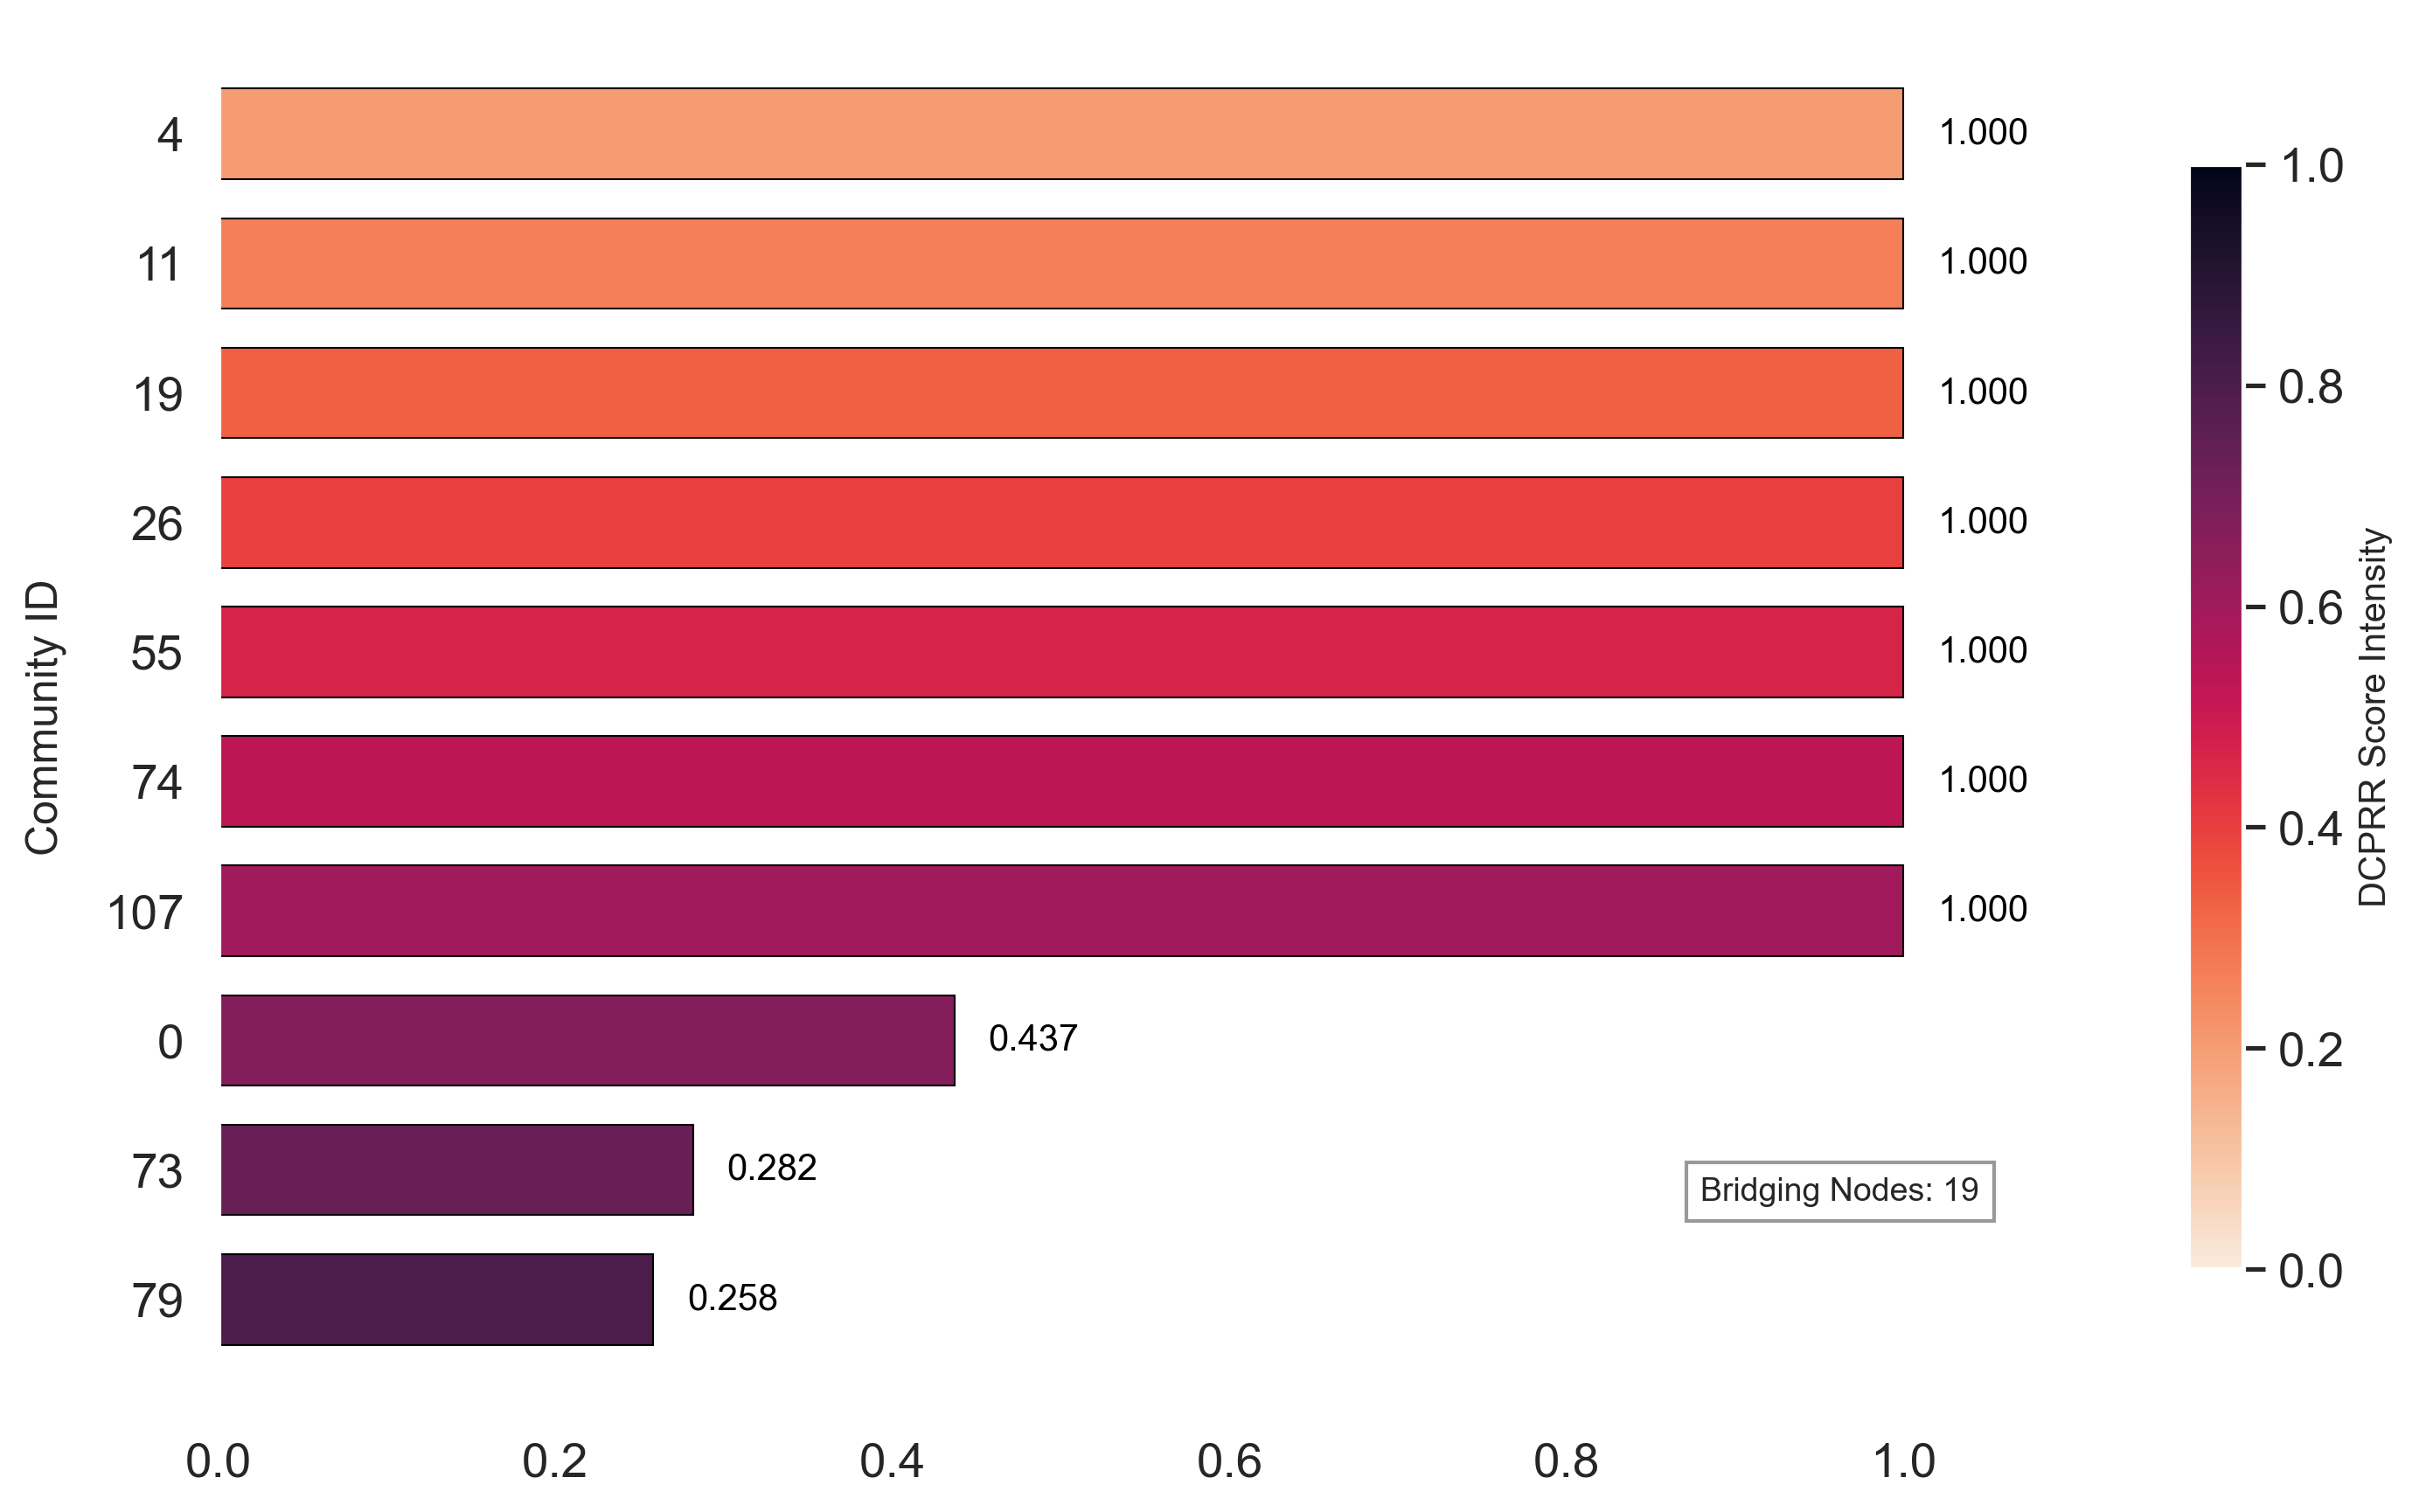

可视化结果已保存至: DCPRR_visualization1.png


In [81]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def visualize_dcprr_scores(dcprr_scores, save_path="dcprr_plot.png"):
    """
    可视化DCPRR得分字典，生成学术风格的水平柱状图。
    
    Parameters:
        dcprr_scores (dict): 社区ID到DCPRR得分的映射，例如 {0: 0.8, 1: 0.5, ...}
        save_path (str): 图片保存路径（推荐PDF格式以保持矢量质量）
    """
    # 设置全局样式
    plt.style.use('seaborn-v0_8-whitegrid')
    sns.set(font_scale=1.2, rc={"axes.facecolor": (0, 0, 0, 0)})  # 透明背景
    
    # 提取社区ID和得分并排序
    communities = sorted(dcprr_scores.keys(), key=lambda x: dcprr_scores[x], reverse=True)
    scores = [dcprr_scores[comm] for comm in communities]
    
    # 创建画布
    fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
    
    # 绘制水平柱状图（渐变颜色）
    cmap = plt.cm.get_cmap("rocket_r")  # 使用火箭色系（从亮到暗）
    colors = cmap(np.linspace(0.2, 0.8, len(communities)))  # 避免使用极端颜色
    
    bars = ax.barh(
        y=np.arange(len(communities)),
        width=scores,
        height=0.7,
        color=colors,
        edgecolor='black',
        linewidth=0.5
    )
    
    # 添加得分标签
    for i, (score, bar) in enumerate(zip(scores, bars)):
        ax.text(
            x=score + 0.02,  # 标签位置（得分右侧）
            y=bar.get_y() + bar.get_height()/2,
            s=f"{score:.3f}",
            va='center',
            ha='left',
            fontsize=10,
            color='black'
        )
    
    # 设置坐标轴标签和标题
    ax.set_yticks(np.arange(len(communities)))
    ax.set_yticklabels(communities)
    #ax.set_xlabel('Dynamic Community Path Retention Rate (DCPRR)', fontsize=12, labelpad=10)
    ax.set_ylabel('Community ID', fontsize=12, labelpad=10)
    #ax.set_title('DCPRR Scores Across Communities', fontsize=14, pad=20, weight='bold')
    # 标注桥接节点数量
    ax.text(0.95, 0.15, f'Bridging Nodes: {len(bridging_nodes)}',
            transform=ax.transAxes, ha='right', fontsize=9,
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))
    
    # 设置坐标轴范围
    ax.set_xlim(0, 1.1)  # DCPRR得分通常为[0,1]
    ax.invert_yaxis()    # 最高分显示在顶部
    
    # 添加颜色条
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0, vmax=1))
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', shrink=0.8, aspect=20)
    cbar.set_label('DCPRR Score Intensity', fontsize=10)
    
    # 优化布局并保存
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight', transparent=True)
    plt.show()
    plt.close()
    print(f"可视化结果已保存至: {save_path}")

# 示例调用
if __name__ == "__main__":

    visualize_dcprr_scores(dcprr_scores , save_path="DCPRR_visualization1.png")

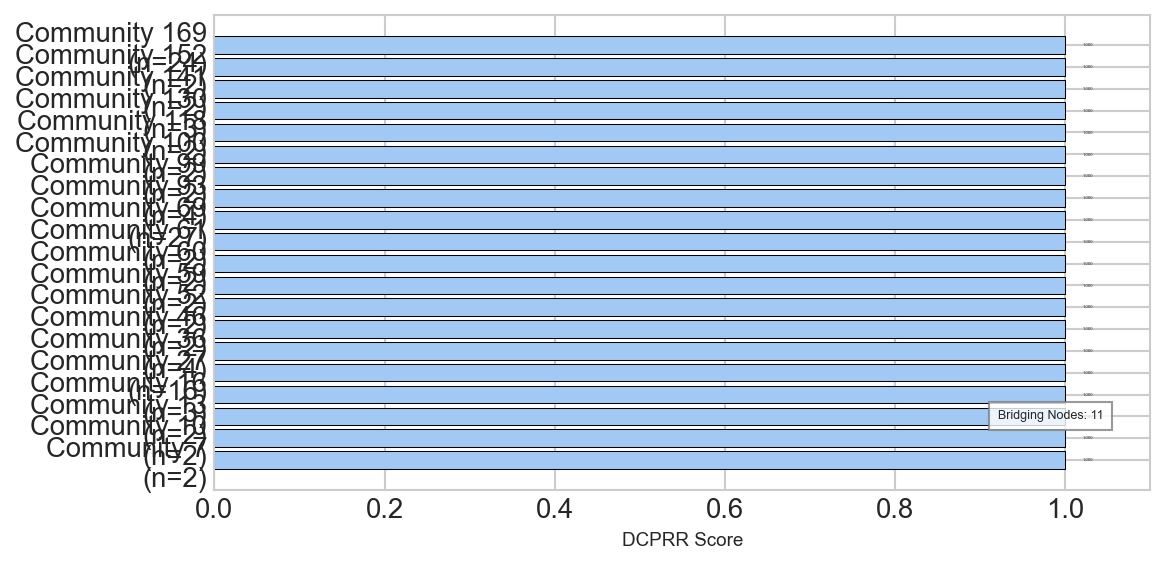

In [41]:
def visualize_small_graph_results(result, save_path="small_graph_analysis.png"):
    """
    小规模图结果可视化（紧凑型水平柱状图）
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    plt.style.use('seaborn-v0_8-whitegrid')
    sns.set_palette("pastel")  # 使用柔和色系
    
    fig, ax = plt.subplots(figsize=(8, 4), dpi=150)
    
    # 数据准备
    communities = sorted(result['dcprr_scores'].keys())[0:20]
    scores = [result['dcprr_scores'][comm] for comm in communities]
    labels = [f"Community {comm}\n(n={len(result['communities'][comm])})" for comm in communities]
    
    # 绘制柱状图
    bars = ax.barh(labels, scores, edgecolor='black', linewidth=0.5)
    
    # 添加数值标签
    for bar in bars:
        width = bar.get_width()
        ax.text(width + 0.02, bar.get_y() + bar.get_height()/2, 
                f'{width:.3f}', va='center', fontsize=2)
    
    # 标注桥接节点数量
    ax.text(0.95, 0.15,f'Bridging Nodes: {len(result["bridging_nodes"])}',
            transform=ax.transAxes, ha='right', fontsize=6,
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray'))
    
    # 美化布局
    ax.set_xlim(0, 1.1)
    ax.set_xlabel('DCPRR Score', fontsize=9)
    #ax.set_title('Small Network Analysis', fontsize=11, pad=12)
    plt.tight_layout()
    plt.savefig(save_path, transparent=True)
    plt.show()
    plt.close()
visualize_small_graph_results(result)

In [18]:
G.number_of_nodes()

1553

In [19]:
# 1. 度分布
d = dict(nx.degree(G))  # 计算每个节点的度
d_avg = sum(d.values()) / len(G.nodes)  # 计算平均度
d_list = nx.degree_histogram(G)  # 获取每个度值出现的次数
y = np.array(d_list) / len(G)  # 计算每个度值的出现概率
y

array([6.58725048e-01, 1.30070831e-01, 6.76110753e-02, 2.89761751e-02,
       2.44687701e-02, 8.37089504e-03, 7.08306504e-03, 3.86349002e-03,
       1.93174501e-03, 1.93174501e-03, 2.57566001e-03, 1.28783001e-03,
       1.93174501e-03, 1.93174501e-03, 4.50740502e-03, 5.79523503e-03,
       5.15132003e-03, 1.93174501e-03, 4.50740502e-03, 2.57566001e-03,
       1.93174501e-03, 3.86349002e-03, 3.86349002e-03, 6.43915003e-04,
       4.50740502e-03, 1.93174501e-03, 2.57566001e-03, 3.86349002e-03,
       1.93174501e-03, 4.50740502e-03, 3.21957502e-03, 1.93174501e-03])

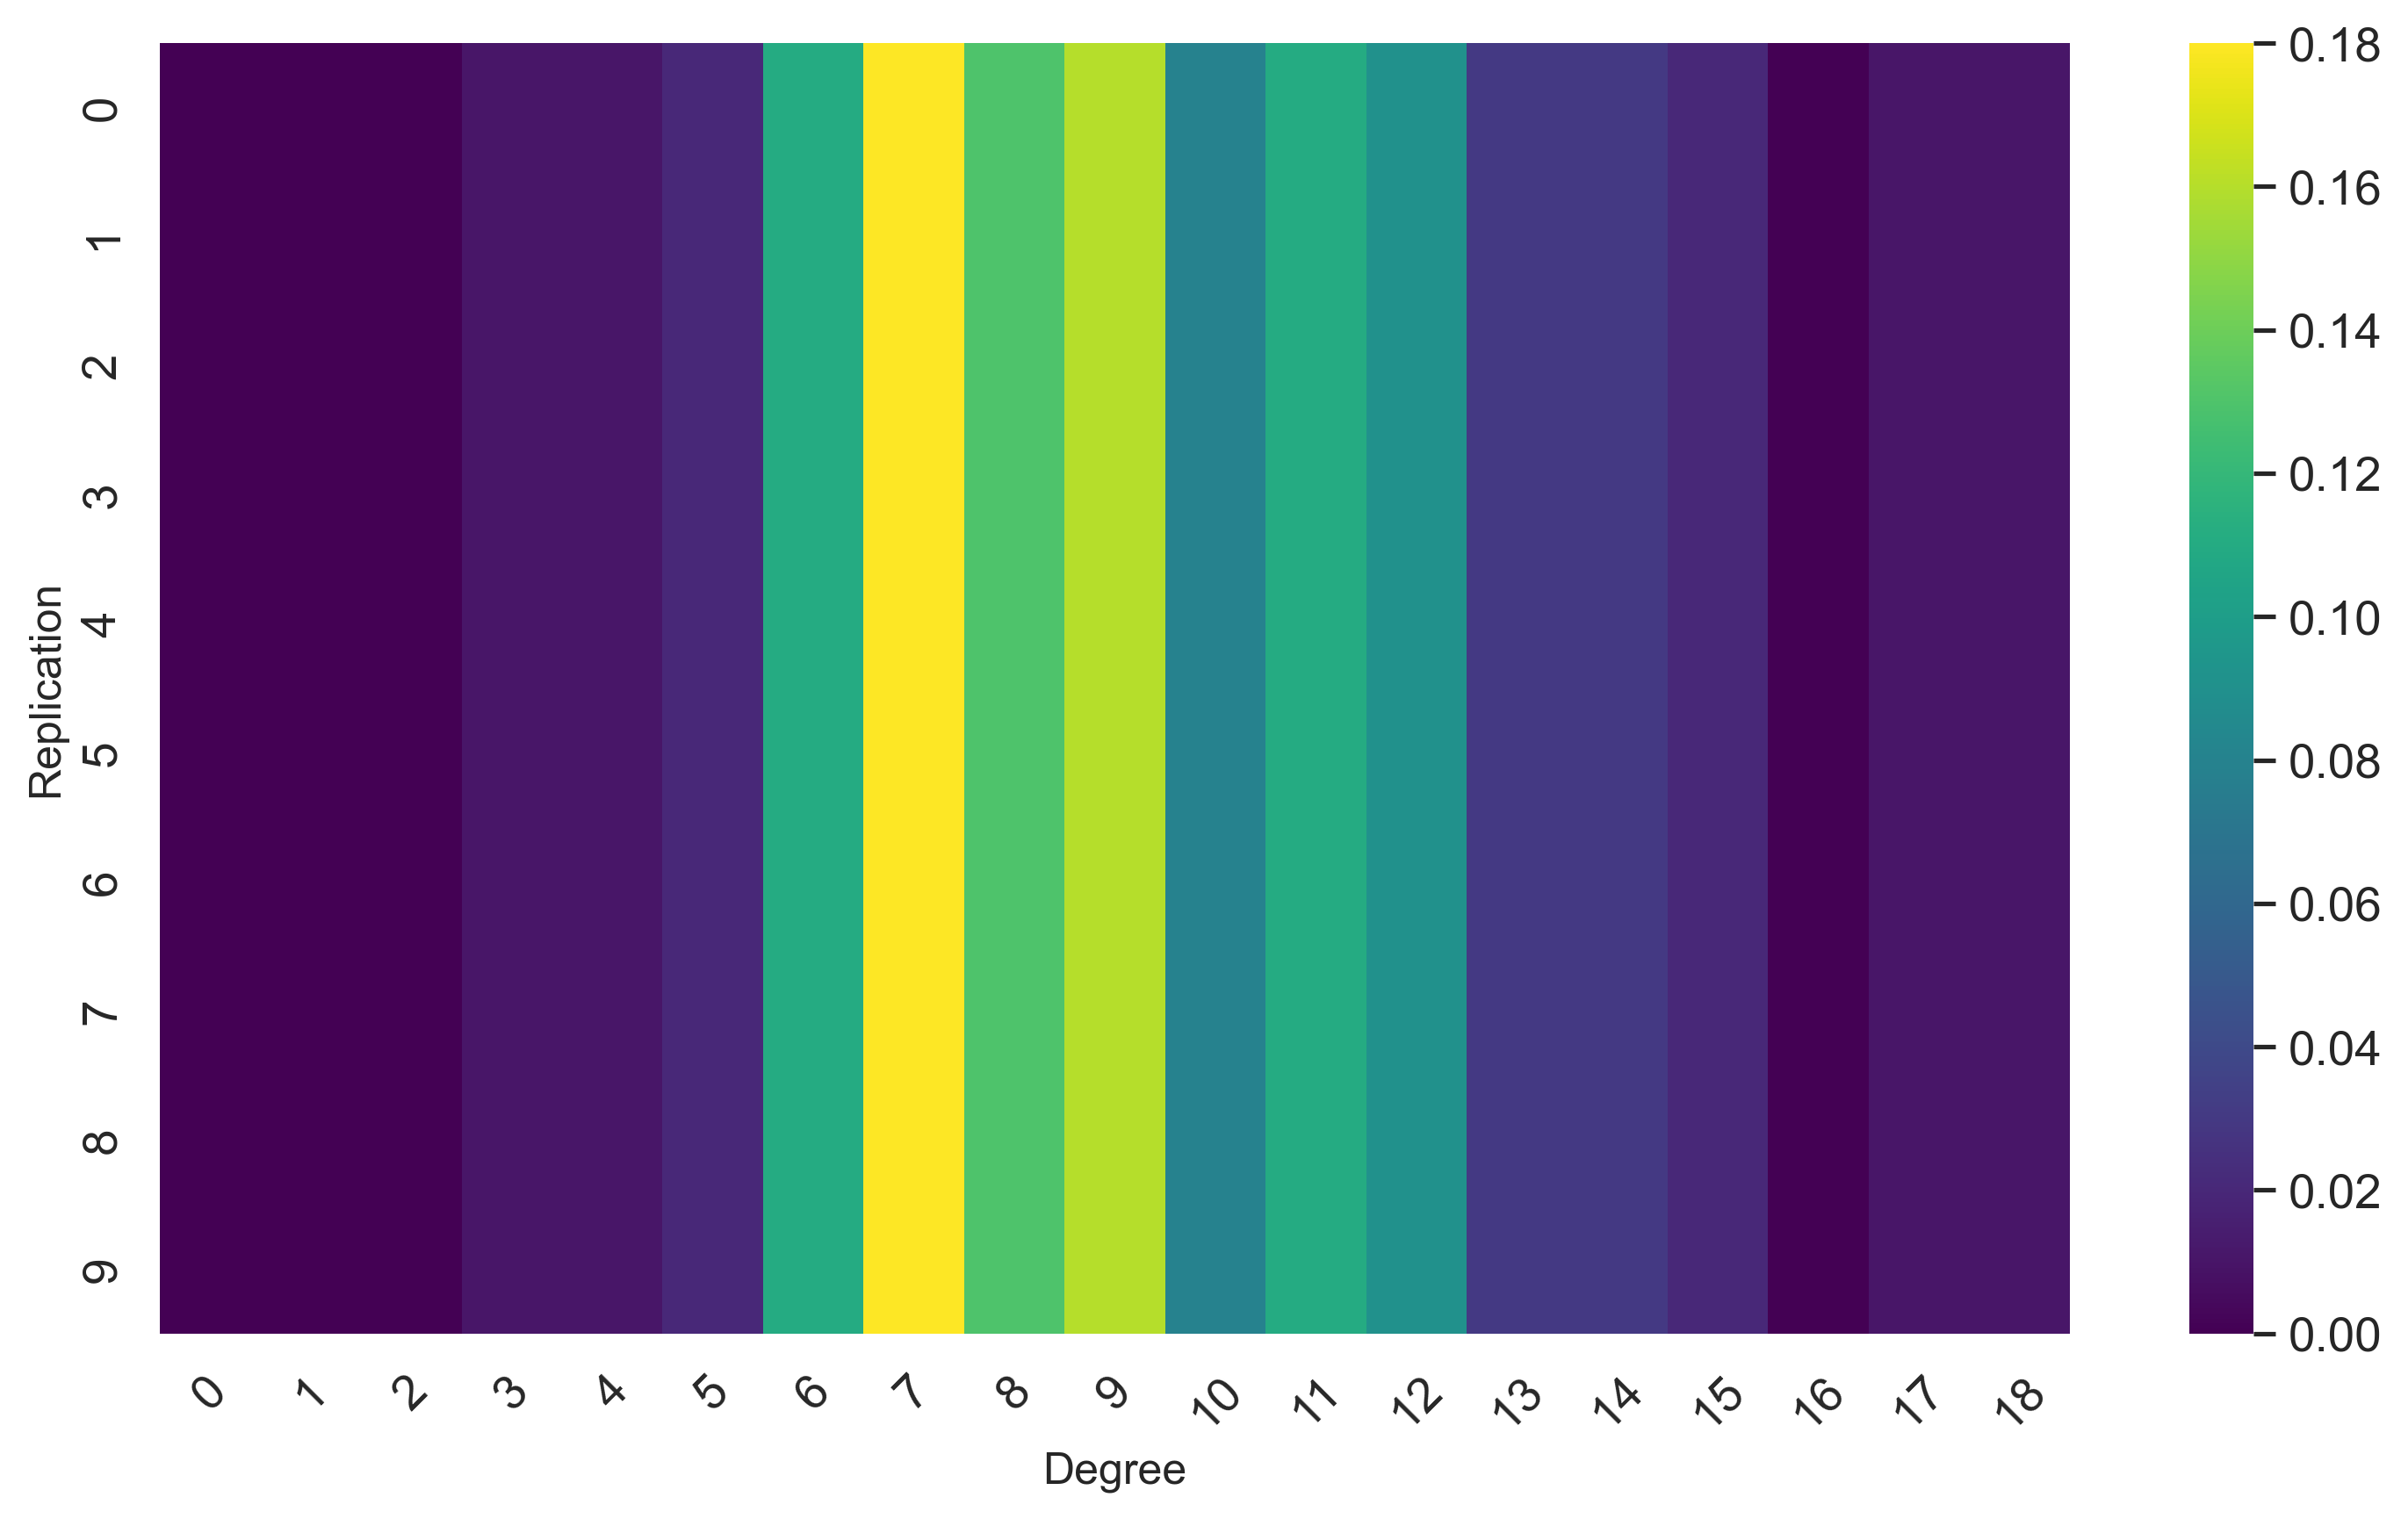

In [31]:
import networkx as nx
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# 假设 G 是一个已经定义好的图
# 这里我们创建一个示例图
G = nx.erdos_renyi_graph(100, 0.1)

# 1. 度分布
d = dict(nx.degree(G))  # 计算每个节点的度
d_avg = sum(d.values()) / len(G.nodes)  # 计算平均度
d_list = nx.degree_histogram(G)  # 获取每个度值出现的次数
y = np.array(d_list) / len(G)  # 计算每个度值的出现概率

# 将一维数组 y 转换为二维矩阵
# 这里我们将 y 复制 10 次形成一个二维矩阵
matrix = np.tile(y, (10, 1))

# 设置图片清晰度
plt.rcParams['figure.dpi'] = 300

# 绘制热力图
plt.figure(figsize=(10, 6))
sns.heatmap(matrix, cmap='viridis', annot=False, cbar=True, square=False)

# 设置标题和坐标轴标签
#plt.title('Degree Distribution Heatmap(Implict)', fontsize=16)
plt.xlabel('Degree', fontsize=12)
plt.xticks(rotation=45)
plt.ylabel('Replication', fontsize=12)
plt.savefig('Degree Distribution Heatmap(Implict)', bbox_inches='tight', transparent=True)
# 显示图形
plt.tight_layout()
plt.show()

AttributeError: QuadMesh.set() got an unexpected keyword argument 'fontsize'

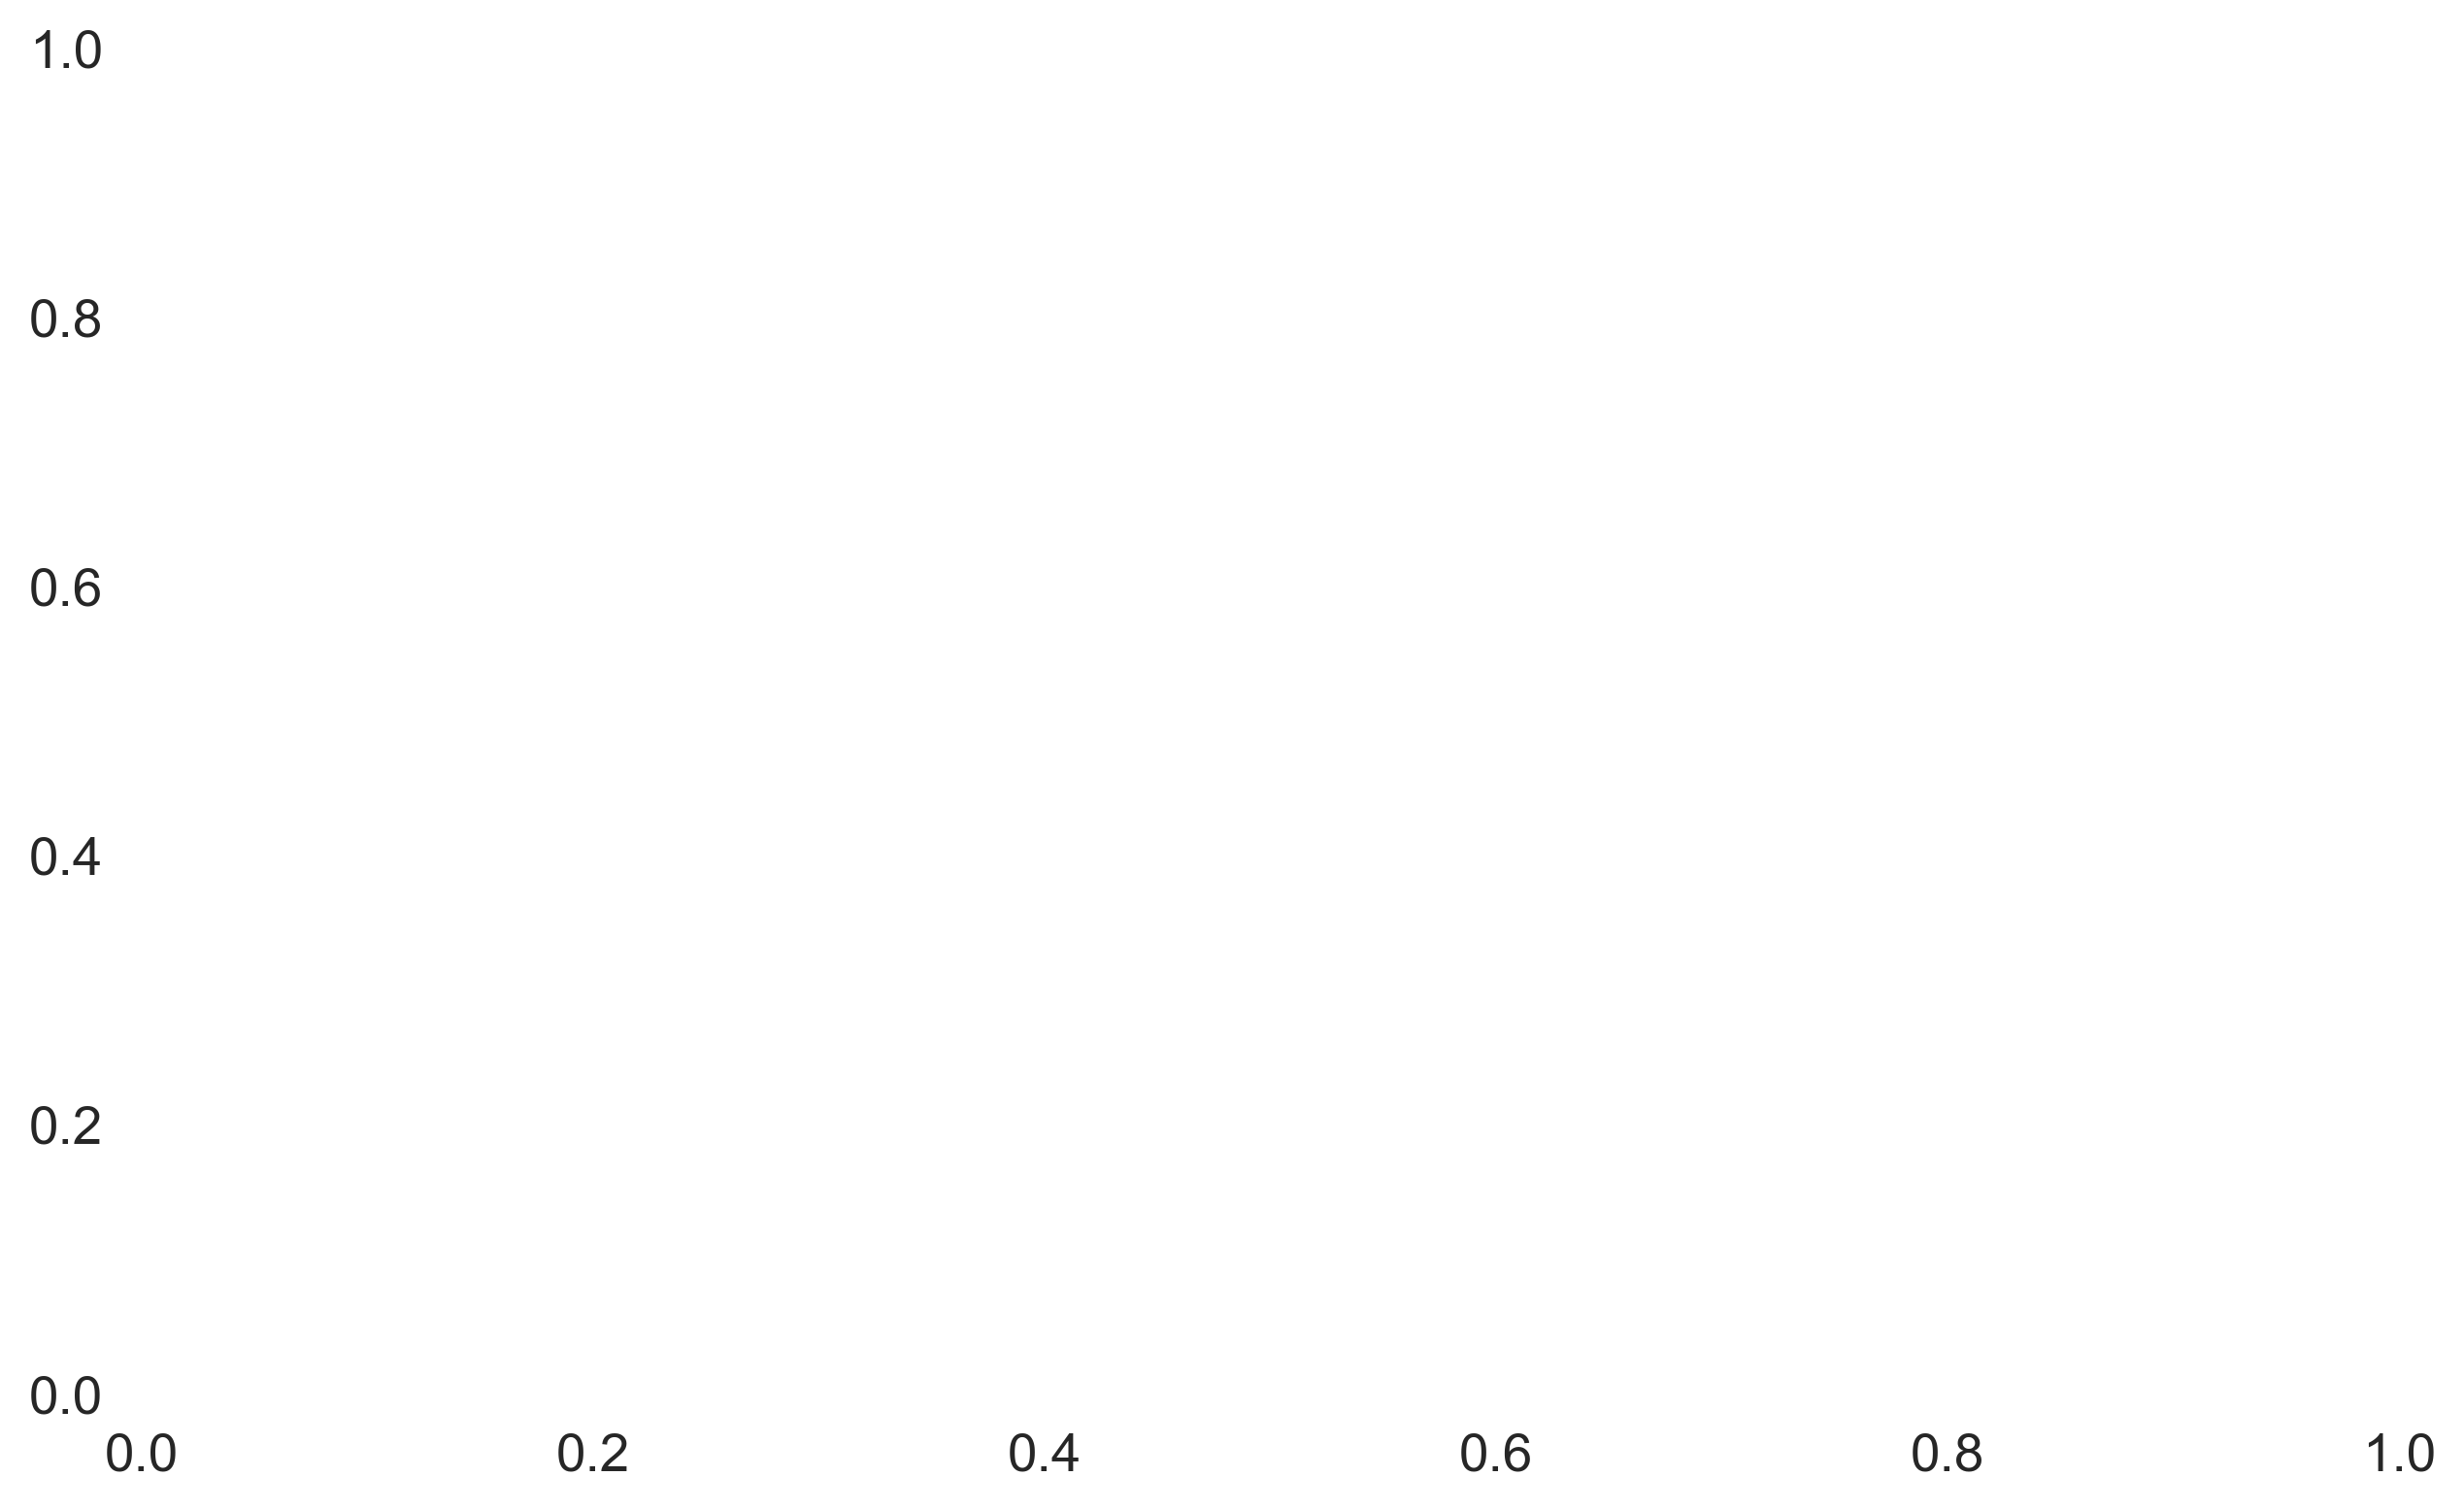

In [24]:
df = pd.DataFrame(y).T
df.columns = range(len(y))

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df, cmap='viridis', annot=True, fmt='.2f', linewidths=.5, cbar_kws={"shrink": .5},fontsize=10)
plt.title('Degree Distribution Heatmap')
plt.xlabel('Degree')
plt.ylabel('Replication')
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.colorbar(label='Probability')
plt.show()

In [27]:
import networkx as nx
import random

# 假设你已经构建了一个图 G
L = 200  # 网格大小
G = nx.grid_2d_graph(L, L, periodic=True)

# 生成时间图序列（假设每个时间步的图是 G 的一个随机子图）
def generate_temporal_graph(base_graph, num_time_steps, edge_retention_prob=0.8):
    """
    生成时间图序列
    
    参数:
    base_graph (networkx.Graph): 基础图
    num_time_steps (int): 时间步数量
    edge_retention_prob (float): 每条边在每个时间步保留的概率
    
    返回:
    list of networkx.Graph: 时间图序列
    """
    temporal_graph = []
    for _ in range(num_time_steps):
        # 复制基础图并随机删除一些边
        G_t = base_graph.copy()
        edges_to_remove = [e for e in G_t.edges() if random.random() > edge_retention_prob]
        G_t.remove_edges_from(edges_to_remove)
        temporal_graph.append(G_t)
    return temporal_graph

# 计算局部不稳定性
def calculate_local_instability(temporal_graph):
    """
    计算局部不稳定性 (Locally η-unstable)
    
    参数:
    temporal_graph (list of networkx.Graph): 时间图序列，每个元素是一个时间步的图
    
    返回:
    int: 局部不稳定性 η
    """
    eta = 0
    for t in range(len(temporal_graph) - 1):
        G_t = temporal_graph[t]
        G_t_plus_1 = temporal_graph[t + 1]
        for v in G_t.nodes():
            N_t = set(G_t.neighbors(v))
            N_t_plus_1 = set(G_t_plus_1.neighbors(v))
            diff_1 = N_t - N_t_plus_1  # N_t(v) \ N_{t+1}(v)
            diff_2 = N_t_plus_1 - N_t  # N_{t+1}(v) \ N_t(v)
            eta = max(eta, len(diff_1), len(diff_2))
    return eta

# 计算成对不稳定性
def calculate_pairwise_instability(temporal_graph, delta_1):
    """
    计算成对不稳定性 (Pairwise η-unstable)
    
    参数:
    temporal_graph (list of networkx.Graph): 时间图序列，每个元素是一个时间步的图
    delta_1 (int): 时间区间长度
    
    返回:
    int: 成对不稳定性 η
    """
    eta = 0
    for t in range(len(temporal_graph) - delta_1):
        G_interval = nx.Graph()
        for i in range(t, t + delta_1 + 1):
            G_interval = nx.compose(G_interval, temporal_graph[i])
        
        for u in G_interval.nodes():
            for v in G_interval.nodes():
                if u != v:
                    CN_interval = set(G_interval.neighbors(u)).intersection(set(G_interval.neighbors(v)))
                    for ell in range(1, len(temporal_graph) - t - delta_1):
                        G_extended = nx.Graph()
                        for i in range(t - ell, t + delta_1 + ell + 1):
                            if 0 <= i < len(temporal_graph):
                                G_extended = nx.compose(G_extended, temporal_graph[i])
                        CN_extended = set(G_extended.neighbors(u)).intersection(set(G_extended.neighbors(v)))
                        diff = CN_extended - CN_interval
                        eta = max(eta, len(diff) // (2 * ell))
    return eta

# 主程序
if __name__ == "__main__":
    # 生成时间图序列
    num_time_steps = 10  # 时间步数量
    edge_retention_prob = 0.8  # 每条边在每个时间步保留的概率
    temporal_graph = generate_temporal_graph(G, num_time_steps, edge_retention_prob)

    # 计算局部不稳定性
    local_eta = calculate_local_instability(temporal_graph)
    print(f"Local Instability (η): {local_eta}")

    # 计算成对不稳定性
    delta_1 = 1  # 时间区间长度
    pairwise_eta = calculate_pairwise_instability(temporal_graph, delta_1)
    print(f"Pairwise Instability (η): {pairwise_eta}")

Local Instability (η): 4


KeyboardInterrupt: 

In [28]:
nx.degree_assortativity_coefficient(G)  # 度同配系数

/home/root_gdut/miniconda3/envs/network/lib/python3.9/site-packages/networkx/algorithms/assortativity/correlation.py:302: RuntimeWarning: invalid value encountered in scalar divide
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)


np.float64(nan)